In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [16]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
sigma2 = 0.2 # Realized vol of the path (greater than vol used in BS price - we underestimate)
q = 0
T = 20/52 #20/52
K = 50
type = 'c'

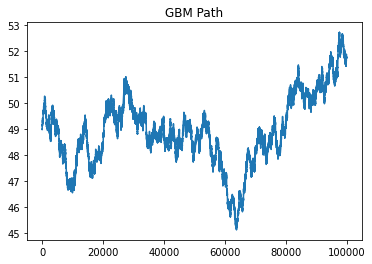

In [17]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
M = 100000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma2*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [18]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)*np.exp(-q*T)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma*np.exp(-q*T)/(2*np.sqrt(T)) + q*S*norm.cdf(d1)*np.exp(-q*T)


#### Delta Hedging

In [19]:
summary_df = pd.DataFrame(list(zip(S, delta_array, gamma_array, theta_array)), columns=['Stock_Price', 'Delta', 'Gamma', 'Theta'])

In [20]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Interest_Cost'] = summary_df['Cumulative_Cost']*(r*dt)
summary_df['Cumulative_Cost_Inc_Interest'] =  summary_df['Cumulative_Cost'].add(summary_df['Interest_Cost'].shift()).fillna(summary_df['Cumulative_Cost'])
summary_df['Portfolio_Delta'] = option_exposure*summary_df['Delta'] + summary_df['Shares_Held']*1
summary_df['Portfolio_Gamma'] = option_exposure*summary_df['Gamma'] + summary_df['Shares_Held']*0
summary_df['Portfolio_Theta'] = option_exposure*summary_df['Theta'] + summary_df['Shares_Held']*0

hedging_cost = -K*option_exposure - summary_df['Cumulative_Cost_Inc_Interest'].iloc[-1]  # Cash received for stock - total cost  

print(f'Hedging PnL = ${hedging_cost}')
summary_df

Hedging PnL = $-197519.4585533319


,Stock_Price,Delta,Gamma,Theta,Shares_Held,Shares_Purchased,Cost_of_Shares_Purchased,Cumulative_Cost,Interest_Cost,Cumulative_Cost_Inc_Interest,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta
0,49.000000,0.521605,0.065544,-4.305330,52160.466107,52160.466107,2.555863e+06,2.555863e+06,0.491517,2.555863e+06,0.0,-6554.403935,430532.982293
1,48.984449,0.520584,0.065574,-4.302275,52058.441767,-102.024339,-4.997606e+03,2.550865e+06,0.490556,2.550866e+06,0.0,-6557.405795,430227.461645
2,48.992448,0.521108,0.065559,-4.303871,52110.807770,52.366002,2.565539e+03,2.553431e+06,0.491049,2.553431e+06,0.0,-6555.917543,430387.140881
3,48.979195,0.520238,0.065585,-4.301262,52023.831203,-86.976567,-4.260042e+03,2.549171e+06,0.490230,2.549171e+06,0.0,-6558.466461,430126.245458
4,49.022982,0.523108,0.065501,-4.309889,52310.750578,286.919375,1.406564e+04,2.563236e+06,0.492935,2.563237e+06,0.0,-6550.076444,430988.910079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51.793908,1.000000,0.000000,-2.499998,100000.000000,-0.000000,-0.000000e+00,5.197518e+06,0.999533,5.197519e+06,0.0,0.000000,249999.807690
99996,51.789102,1.000000,0.000000,-2.499999,100000.000000,-0.000000,-0.000000e+00,5.197518e+06,0.999533,5.197519e+06,0.0,0.000000,249999.855768
99997,51.762288,1.000000,0.000000,-2.499999,100000.000000,-0.000000,-0.000000e+00,5.197518e+06,0.999533,5.197519e+06,0.0,0.000000,249999.903845
99998,51.769347,1.000000,0.000000,-2.500000,100000.000000,-0.000000,-0.000000e+00,5.197518e+06,0.999533,5.197519e+06,0.0,0.000000,249999.951923


In [21]:
profit_df = summary_df[['Stock_Price', 'Interest_Cost', 'Portfolio_Delta', 'Portfolio_Gamma', 'Portfolio_Theta', 'Shares_Held']].copy()
profit_df['Stock_Ret'] = profit_df['Stock_Price'].div(profit_df['Stock_Price'].shift()) - 1
profit_df['Stock_Change'] = profit_df['Stock_Price'].sub(profit_df['Stock_Price'].shift())
profit_df['BS_Option_Price'] = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type, display_result=False)
profit_df['Option_Exposure'] = option_exposure*profit_df['BS_Option_Price']
profit_df['Share_Exposure'] = profit_df['Shares_Held'].mul(profit_df['Stock_Price'])
profit_df['Option_PnL'] = -profit_df['Option_Exposure'].shift().sub(profit_df['Option_Exposure'])
profit_df['Share_PnL'] = profit_df['Share_Exposure'].mul(profit_df['Stock_Ret'].shift(-1)).shift()
profit_df['Portfolio_PnL'] = profit_df['Share_PnL'].add(profit_df['Option_PnL'])
profit_df['Projected_Portfolio_Pnl_Delta'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])
profit_df['Projected_Portfolio_Pnl_Delta_Gamma'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])
profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2) - profit_df['Interest_Cost']

profit_df = profit_df.astype(float).round(4)
profit_df

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))


,Stock_Price,Interest_Cost,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta,Shares_Held,Stock_Ret,Stock_Change,BS_Option_Price,Option_Exposure,Share_Exposure,Option_PnL,Share_PnL,Portfolio_PnL,Projected_Portfolio_Pnl_Delta,Projected_Portfolio_Pnl_Delta_Gamma,Projected_Portfolio_Pnl_Delta_Gamma_Theta,Projected_Portfolio_Pnl_Delta_Theta,Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest
0,49.0000,0.4915,0.0,-6554.4039,430532.9823,52160.4661,NaN,NaN,2.4005,-240052.7323,2.555863e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.9844,0.4906,0.0,-6557.4058,430227.4616,52058.4418,-0.0003,-0.0156,2.3924,-239240.7429,2.550054e+06,811.9894,-811.1273,0.8621,-0.0,-0.7925,0.8634,1.6559,0.3729
2,48.9924,0.4910,0.0,-6555.9175,430387.1409,52110.8078,0.0002,0.0080,2.3966,-239655.6756,2.553036e+06,-414.9327,416.3783,1.4456,0.0,-0.2097,1.4450,1.6547,0.9539
3,48.9792,0.4902,0.0,-6558.4665,430126.2455,52023.8312,-0.0003,-0.0133,2.3896,-238963.9891,2.548085e+06,691.6865,-690.6080,1.0786,-0.0,-0.5757,1.0796,1.6554,0.5894
4,49.0230,0.4929,0.0,-6550.0764,430988.9101,52310.7506,0.0009,0.0438,2.4125,-241246.5992,2.564429e+06,-2282.6101,2277.9830,-4.6270,0.0,-6.2874,-4.6330,1.6543,-5.1260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51.7939,0.9995,0.0,0.0000,249999.8077,100000.0000,0.0002,0.0087,1.7939,-179394.6728,5.179391e+06,-865.3922,866.3538,0.9615,0.0,0.0000,0.9615,0.9615,-0.0380
99996,51.7891,0.9995,0.0,0.0000,249999.8558,100000.0000,-0.0001,-0.0048,1.7891,-178913.0710,5.178910e+06,481.6018,-480.6402,0.9615,-0.0,0.0000,0.9615,0.9615,-0.0380
99997,51.7623,0.9995,0.0,0.0000,249999.9038,100000.0000,-0.0005,-0.0268,1.7623,-176230.7279,5.176229e+06,2682.3431,-2681.3816,0.9615,-0.0,0.0000,0.9615,0.9615,-0.0380
99998,51.7693,0.9995,0.0,0.0000,249999.9519,100000.0000,0.0001,0.0071,1.7694,-176935.6122,5.176935e+06,-704.8843,705.8458,0.9615,0.0,0.0000,0.9615,0.9615,-0.0380


In [22]:
print(profit_df['Portfolio_PnL'].sum()) # Actual PnL of the portfolio
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma at time t
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma, Theta at time t
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma, Theta at time t, including borring costs

42534.26409999999
-183243.19389999998
42534.6885
-4512.3884


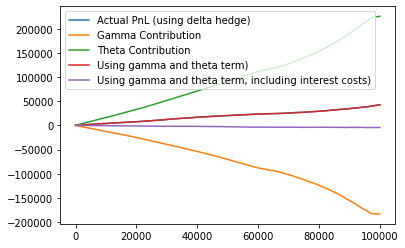

In [23]:
plt.plot(profit_df['Portfolio_PnL'].cumsum(), label='Actual PnL (using delta hedge)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].cumsum(), label='Gamma Contribution')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Theta'].cumsum(), label='Theta Contribution')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].cumsum(), label='Using gamma and theta term)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'].cumsum(), label='Using gamma and theta term, including interest costs)')

plt.legend()
plt.show()

In [24]:
(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'] - profit_df['Projected_Portfolio_Pnl_Delta_Theta']).max()

-0.9615

In [25]:
profit_df['Share_PnL'].sum()

-21836.677799999976

In [26]:
profit_df['Option_PnL'].sum()

64370.95349999986

In [27]:
profit_df['Interest_Cost'].sum()

47047.575899999996

In [28]:
total_hedging_cost = profit_df['Interest_Cost'].sum() - profit_df['Share_PnL'].sum()
discounted_hedging_cost = np.exp(-r*T)*total_hedging_cost
print(discounted_hedging_cost)

67572.21272698672
